# Global Meridional Overturning (MOC)

This notebook plots the global MOC in depth and isopycnal (`rho2`) space as well as a break down of the Indo-Pacific and Atlantic basin.

In [1]:
import os
import datetime

In [2]:
config = {
    "startyr": "1993",
    "endyr": "2017",
    "dora_id": "odiv-319",
    "pathPP": "/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/"
    + "om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/",
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: Beginning year of analysis from model
* `MAR_ENDYR`: Ending year of analysis from model
* `MAR_DORA_ID`: The experiment ID in the database
* `MAR_PATHPP`: The top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [3]:
for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

### Import Python Modules

In [4]:
import doralite
import glob
import subprocess

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

### Definie Local Parameters

In [5]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

experiment =  doralite.dora_metadata(config["dora_id"])
pathPP = experiment["pathPP"]
expName = experiment["expName"]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

### Determine What Files to Load

In [6]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [7]:
dset = "av" # av, ts

In [16]:
ddict = {component:{} for component in ["ocean_annual_z","ocean_annual_rho2"]}
ddict["ocean_annual_z"]["variables"] = ["vmo"]
ddict["ocean_annual_rho2"]["variables"] = ["vmo","volcello"]

for component in ddict:
    #print(component)
    
    if dset=='ts':
        chunks = os.listdir(os.path.join(pathPP,component,dset,component.split('_')[1])) # ts
    else:
        chunks = os.listdir(os.path.join(pathPP,component,dset)) # av
    if len(chunks)>1:
        print("Warning: More than one chunk size available. Using %s"%sorted(chunks)[-1])
    chunk = sorted(chunks)[-1]
    
    filelist = []
    
    if dset=='ts':
        for varname in ddict[component]["variables"]:
            #print(varname)
            files = sorted(glob.glob(f"{pathPP}{component}/{dset}/{component.split('_')[1]}/{chunk}/{component}.*.{varname}.nc", 
                                     recursive=True)) # ts
    else:
        files = sorted(glob.glob(f"{pathPP}{component}/{dset}/{chunk}/{component}.*.nc", recursive=True)) # av
            
        files_in_range = [x for x in files if is_in_range(x,start,end)]
        filelist = filelist+files_in_range
    ddict[component]["filelist"] = filelist

filelist = []
for component in ddict:
    filelist = filelist+ddict[component]["filelist"]

static = f"{component}/{component}.static.nc"
staticfile = f"{pathPP}{static}"

In [17]:
_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1993-1997.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.1998-2002.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2003-2007.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2008-2012.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/av/annual_5yr/ocean_annual_z.2013-2017.ann.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean

### DMgetting Files

Dora cannot issue calls to dmget

In [18]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [19]:
grid = xr.open_dataset(staticfile)
for component in ddict:
    ddict[component]["ds"] = xr.open_mfdataset(ddict[component]["filelist"],use_cftime=True, 
                                               drop_variables=['average_DT','average_T1','average_T2'])

### Overturning in depth space (`ocean_annual_z`)

In [20]:
rho0 = 1035.0

In [21]:
ds = ddict["ocean_annual_z"]["ds"]

vmo = ds.vmo.where(ds.vmo<1e14)

# Sum over the zonal direction and integrate from bottom
integ_layers = vmo.sum('xh').reindex(z_l=vmo.z_l[::-1]).cumsum('z_l') # Reverse vertical (density) axis and integrate

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'z_l': 0}))

# combine bottom condition with data array
psi_raw = xr.concat([integ_layers.reindex(z_l=integ_layers.z_l[::-1]),bottom_condition], dim='z_l')

# need to rechunk to new size
psi_raw = psi_raw.chunk({'z_l': len(psi_raw['z_l'])})

# rename to correct dimension and add correct vertical coordinate
psi = -psi_raw.rename({'z_l': 'z_i'}).transpose('time','z_i','yq')
psi['z_i'] = ds.z_i
psi.name = 'psi'

# Convert kg.s-1 to Sv (1e6 m3.s-1)
moc_z = psi / rho0 / 1.0e6

moc_z = moc_z.mean('time').load()

In [22]:
contours = np.concatenate([np.arange(-30,0,5),np.arange(5,35,5)])

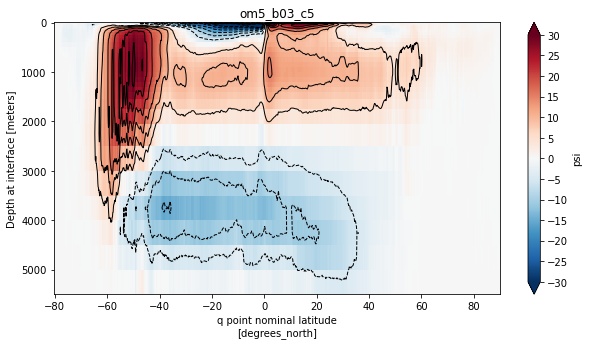

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
moc_z.sel(z_i=slice(None,5500)).plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                                     cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_z.sel(z_i=slice(None,5500)).plot.contour(ax=ax, yincrease=False, colors='k', linewidths=1, levels=contours)
ax.set_title(experiment['expName'])
plt.show()

### Overturning in density space (`ocean_annual_rho2`)

In [24]:
ds = ddict["ocean_annual_rho2"]["ds"]
vmo = ds.vmo.where(ds.vmo<1e14)

# Sum over the zonal direction and integrate along density
integ_layers = (vmo.sum('xh').cumsum('rho2_l') - vmo.sum('xh').sum('rho2_l'))/rho0/1.0e6 + 0.1

# The result of the integration over layers is evaluated at the interfaces
# with psi = 0 as the bottom boundary condition for the integration
bottom_condition = xr.zeros_like(integ_layers.isel({'rho2_l': 0}))

# combine bottom condition with data array
#psi_raw = xr.concat([integ_layers, bottom_condition], dim='rho2_l')
psi_raw = xr.concat([bottom_condition, integ_layers], dim='rho2_l')

# need to rechunk to new size
psi_raw = psi_raw.chunk({'rho2_l': len(psi_raw['rho2_l'])})

# rename to correct dimension and add correct vertical coordinate
psi = psi_raw.rename({'rho2_l': 'rho2_i'}).transpose('time','rho2_i','yq')
psi['rho2_i'] = ds.rho2_i
psi.name = 'psi'
moc_rho2 = psi.mean('time').load()

In [25]:
from om4labs.m6plot.formatting import VerticalSplitScale

/nbhome/jet/miniconda3/envs/python39/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.0-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


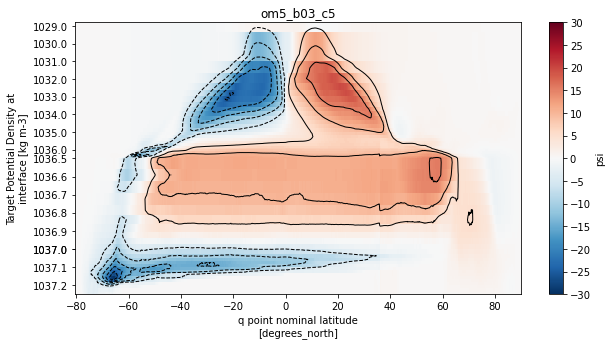

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
moc_rho2.sel(rho2_i=slice(1027.5,None)).plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',
                                             cbar_kwargs={'ticks': np.arange(-30,35,5)})
moc_rho2.sel(rho2_i=slice(1027.5,None)).plot.contour(ax=ax, yincrease=False, levels=contours, colors='k', linewidths=1)
ax.set_yscale('splitscale', zval=[1037.25, 1036.5, 1028.8])
ax.invert_yaxis()
ax.set_title(experiment['expName'])
plt.show()

### Establish a Dictionary to Store Scalar Metrics

### Write Stats to a File